In [2]:
import os
import librosa
import numpy as np
import random
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [3]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_shift(data, sr, n_steps):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def save_augmented_audio(data, sr, filename, augmented_dir, emotion_folder):
    full_path = os.path.join(augmented_dir, emotion_folder, filename)
    sf.write(full_path, data, sr)

def preprocess_and_save(dataset_dir, augmented_dir):
    if not os.path.exists(augmented_dir):
        os.makedirs(augmented_dir)

    for emotion_folder in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, emotion_folder)):
            emotion_folder_path = os.path.join(dataset_dir, emotion_folder)
            if not os.path.exists(os.path.join(augmented_dir, emotion_folder)):
                os.makedirs(os.path.join(augmented_dir, emotion_folder))

            for filename in os.listdir(emotion_folder_path):
                if filename.endswith('.wav'):
                    filepath = os.path.join(emotion_folder_path, filename)
                    audio, sr = librosa.load(filepath, sr=None)
                    if len(audio) == 0:
                        continue
                    save_augmented_audio(audio, sr, f'original_{filename}', augmented_dir, emotion_folder)

                    noisy_audio = add_noise(audio)
                    save_augmented_audio(noisy_audio, sr, f'noisy_{filename}', augmented_dir, emotion_folder)

                    stretched_audio = time_stretch(audio)
                    save_augmented_audio(stretched_audio, sr, f'stretched_{filename}', augmented_dir, emotion_folder)

                    shifted_audio = pitch_shift(audio, sr, n_steps=2)
                    save_augmented_audio(shifted_audio, sr, f'shifted_{filename}', augmented_dir, emotion_folder)
            print(f"Processed files in {emotion_folder}")
            
def load_data_features(augmented_dir, chosen):
    X, y_speakers, y_emotions = [], [], []
    for emotion_folder in os.listdir(augmented_dir):
        if os.path.isdir(os.path.join(augmented_dir, emotion_folder)):
            for filename in os.listdir(os.path.join(augmented_dir, emotion_folder)):
                if filename.endswith('.wav'):
                    filepath = os.path.join(augmented_dir, emotion_folder, filename)
                    audio, sr = librosa.load(filepath, sr=None)
                    if len(audio) == 0:
                        print(f"Skipping empty audio file: {filename}")
                        continue
                    if chosen == 'mfcc':
                        features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                    elif chosen == 'spectral':
                        features = librosa.feature.spectral_contrast(y=audio, sr=sr)
                    elif chosen == 'combined':
                        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
                        features = np.concatenate((mfccs, spectral_contrast), axis=0)
                    else:
                        raise ValueError("Invalid feature type chosen.")
                    X.append(features)
                    y_speakers.append(int(filename.split('(')[-1].split(')')[0]))
                    y_emotions.append(emotion_folder[0])
    return X, y_speakers, y_emotions

def build_lstm_model(input_shape, num_classes): 
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # Using the number of speakers
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    

def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    if len(input_shape) == 2:  
        input_shape = (*input_shape, 1)  

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, y_test_emotions, emotion_encoder, num_classes, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
    overall_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    metrics = calculate_metrics_and_visualize(y_true_classes, y_pred_classes, emotion_encoder)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    return overall_accuracy, metrics

def calculate_metrics_and_visualize(y_true, y_pred, emotion_encoder):
    emotion_label_mapping = {'a': 'anger', 'd': 'disgust', 'f': 'fear', 'h': 'happiness', 's': 'sadness'}
    metrics = {'emotion': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    for emotion_label in emotion_encoder.classes_:
        encoded_label = emotion_encoder.transform([emotion_label])[0]
        indices = (y_true == encoded_label)
        y_true_subset = y_true[indices]
        y_pred_subset = y_pred[indices]

        accuracy = accuracy_score(y_true_subset, y_pred_subset)
        precision = precision_score(y_true_subset, y_pred_subset, average='macro', zero_division=0)
        recall = recall_score(y_true_subset, y_pred_subset, average='macro', zero_division=0)
        f1 = f1_score(y_true_subset, y_pred_subset, average='macro', zero_division=0)

        emotion_name = emotion_label_mapping.get(emotion_label, emotion_label)  # Get full emotion name
        metrics['emotion'].append(emotion_name)
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)

    plt.figure(figsize=(12, 8))
    metrics_keys = [key for key in metrics.keys() if key != 'emotion']
    for i, metric_name in enumerate(metrics_keys):
        ax = plt.subplot(2, 2, i+1)  # Create subplots in a 2x2 layout
        sns_barplot = sns.barplot(x=metrics[metric_name], y=metrics['emotion'], orient='h', ax=ax)
        plt.xlabel('Score')
        plt.ylabel('Emotion')
        plt.title(metric_name.capitalize())
        for bar in sns_barplot.patches:
            ax.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
                    f'{bar.get_width():.2%}', 
                    va='center', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    return metrics

def perform_stratified_cross_validation(build_model_func, X, y, y_emotions, emotion_encoder, num_classes, n_splits=3, epochs=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    fold_idx = 1  

    for train_index, test_index in skf.split(X, y_emotions):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_emotions, y_test_emotions = y_emotions[train_index], y_emotions[test_index]
        y_train_encoded = to_categorical(y_train, num_classes=num_classes)
        y_test_encoded = to_categorical(y_test, num_classes=num_classes)

        model = build_model_func()
        fold_accuracy, metrics = train_and_evaluate_model(model, X_train, y_train_encoded, X_test, y_test_encoded, y_test_emotions, emotion_encoder, num_classes, epochs)
        accuracies.append(fold_accuracy)
        print(f"Completed Fold {fold_idx} with Accuracy: {fold_accuracy:.2f}")
        fold_idx += 1
    average_accuracy = np.mean(accuracies)
    print(f"Average Accuracy: {average_accuracy:.2f}")
    return

def get_max_sequence_length(dataset):
    return max([feature.shape[1] for feature in dataset])

def prepare_and_evaluate(dataset, y_speakers, y_emotions, model_builder, model_input_shape, epochs):
    emotion_encoder = LabelEncoder()
    y_emotions_encoded = emotion_encoder.fit_transform(y_emotions)
    speaker_encoder = LabelEncoder()
    y_speakers_encoded = speaker_encoder.fit_transform(y_speakers)

    max_length = max([feature.shape[1] for feature in dataset])
    X_padded = np.array([pad_sequences(feature, maxlen=max_length, padding='post', dtype='float', truncating='post').T for feature in dataset])
    X_padded = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], X_padded.shape[2])
    num_speakers = len(np.unique(y_speakers_encoded))

    perform_stratified_cross_validation(lambda: model_builder(model_input_shape, num_speakers), X_padded, y_speakers_encoded, y_emotions_encoded, emotion_encoder, num_speakers, epochs=epochs)

In [4]:
# #actual data
# dataset_dir = '/Users/remon.m/Desktop/5305/dataset'
# aug_dir = '/Users/remon.m/Desktop/5305/augmented_dataset'

# preprocess_and_save(dataset_dir, aug_dir)
# epochs = 45

In [5]:
#test data
dataset_dir = '/Users/remon.m/Desktop/5305/test_datasets/dataset_tester'
aug_dir = '/Users/remon.m/Desktop/5305/test_datasets/dataset_tester_aug'

preprocess_and_save(dataset_dir, aug_dir)
epochs = 1

Processed files in fear
Processed files in sadness
Processed files in happiness
Processed files in anger
Processed files in disgust


3/3 [==============================] - 5s 1s/step


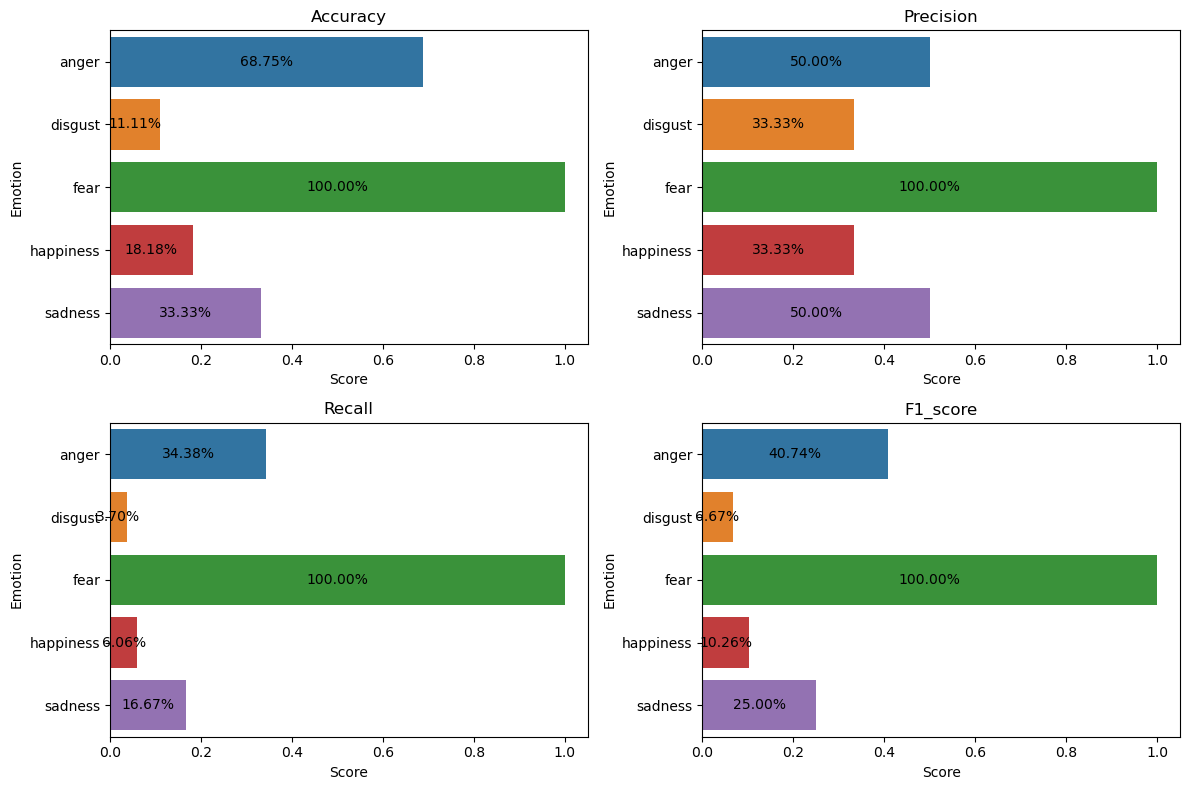

Overall Accuracy: 0.4328
Completed Fold 1 with Accuracy: 0.43
3/3 [==============================] - 6s 1s/step


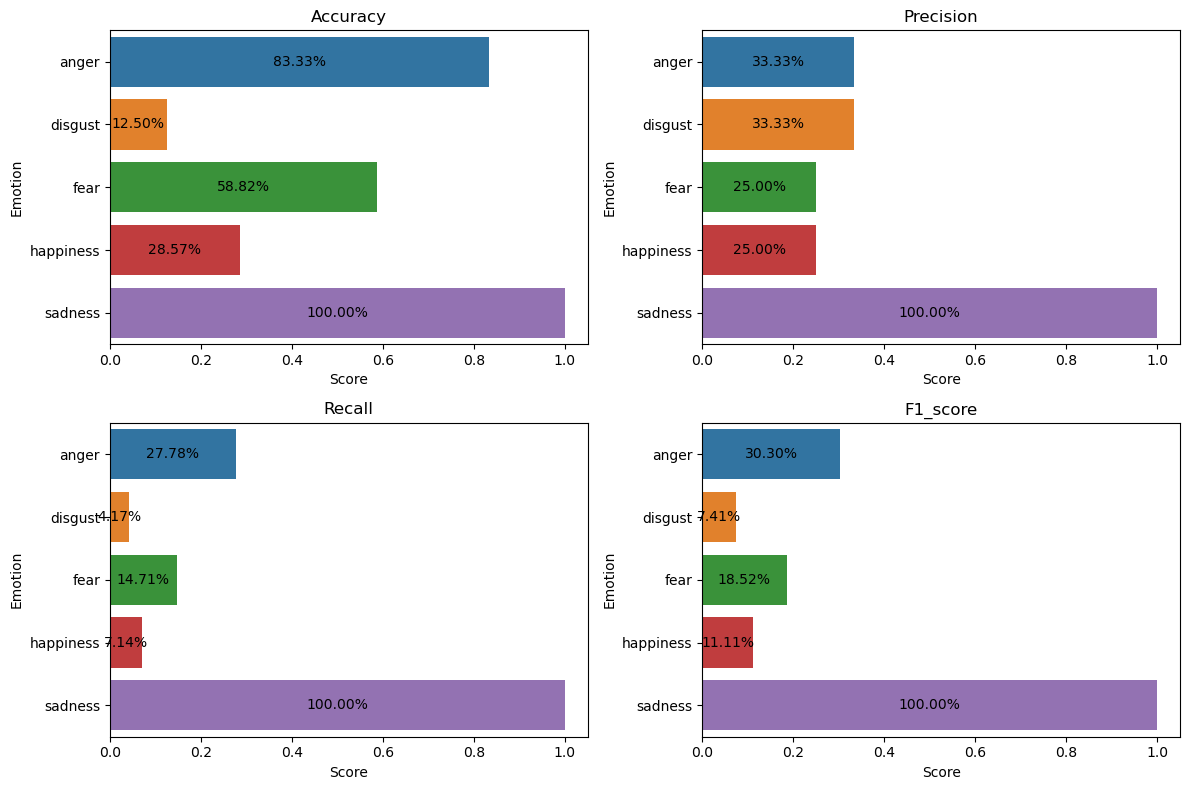

Overall Accuracy: 0.5224
Completed Fold 2 with Accuracy: 0.52
3/3 [==============================] - 2s 553ms/step


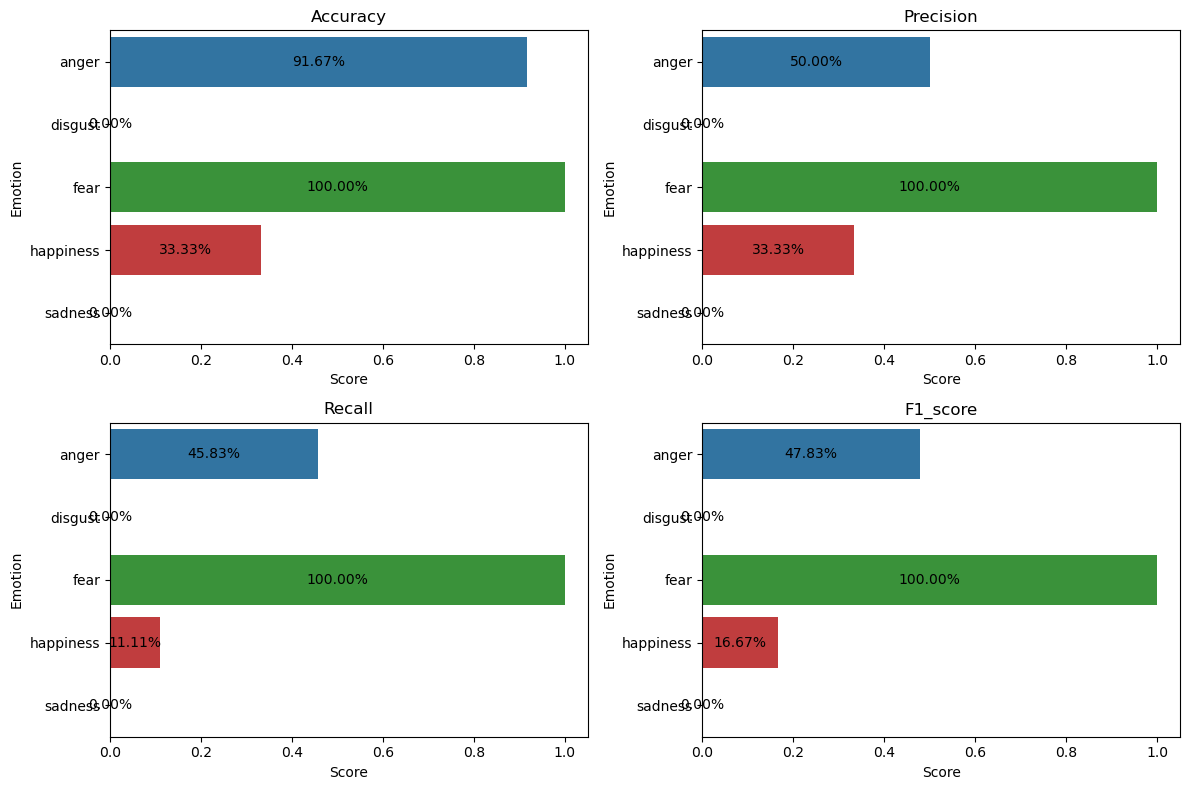

Overall Accuracy: 0.4242
Completed Fold 3 with Accuracy: 0.42
Average Accuracy: 0.46


In [6]:
#mfcc lstm
X, y_speakers, y_emotions = load_data_features(aug_dir, chosen='mfcc')
input_shape = (get_max_sequence_length(X), X[0].shape[0])  
prepare_and_evaluate(X, y_speakers, y_emotions, build_lstm_model, input_shape, epochs)

3/3 [==============================] - 0s 110ms/step


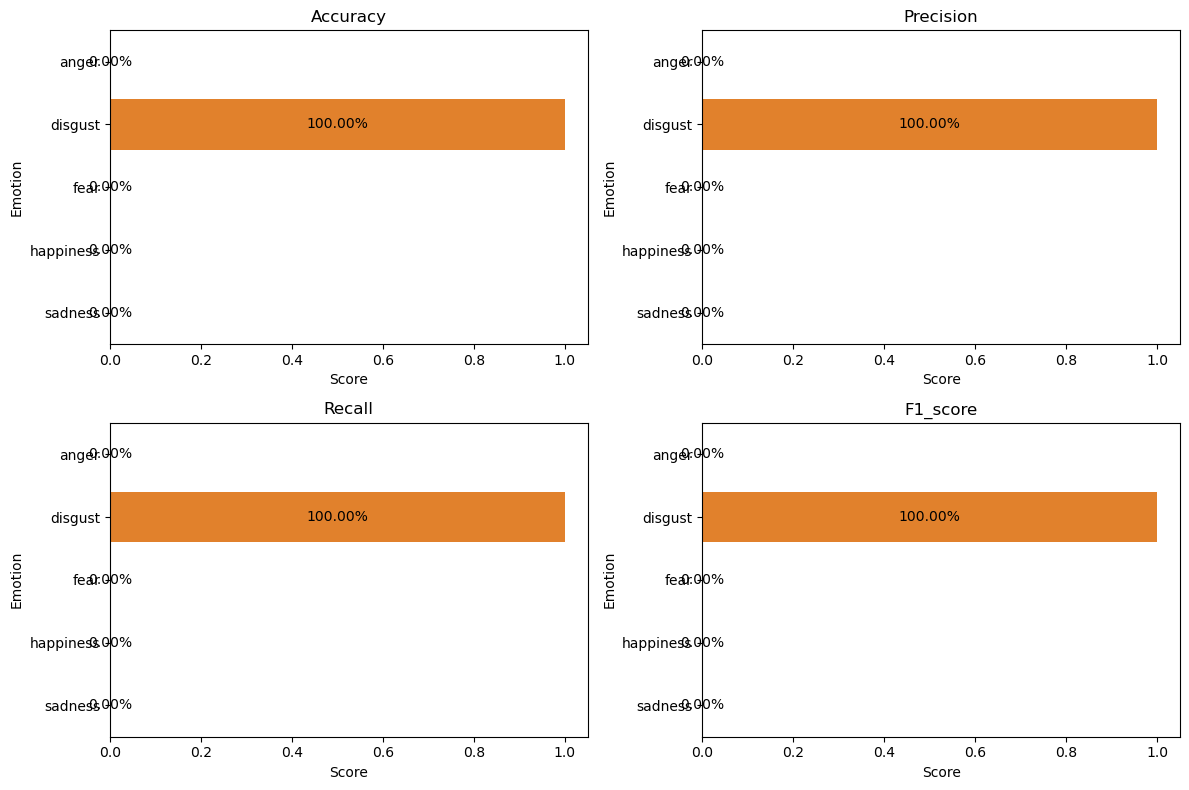

Overall Accuracy: 0.1343
Completed Fold 1 with Accuracy: 0.13
3/3 [==============================] - 0s 67ms/step


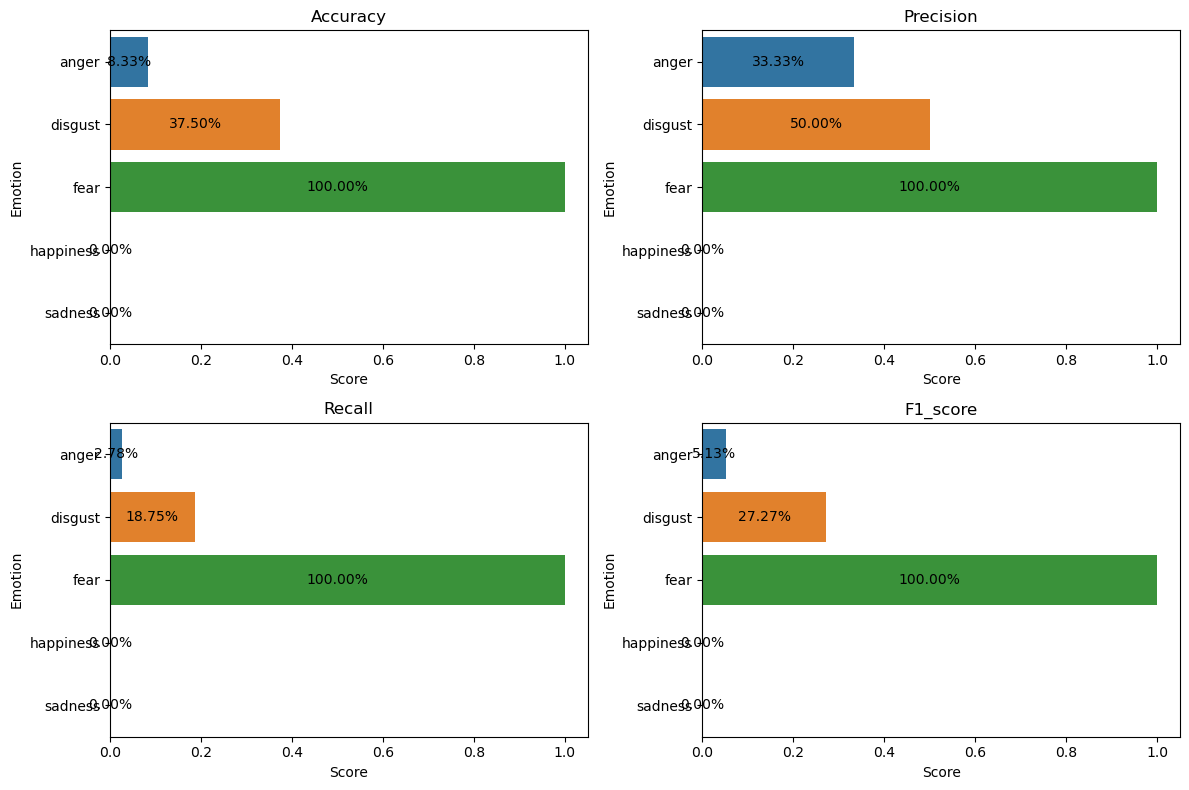

Overall Accuracy: 0.3134
Completed Fold 2 with Accuracy: 0.31
3/3 [==============================] - 0s 122ms/step


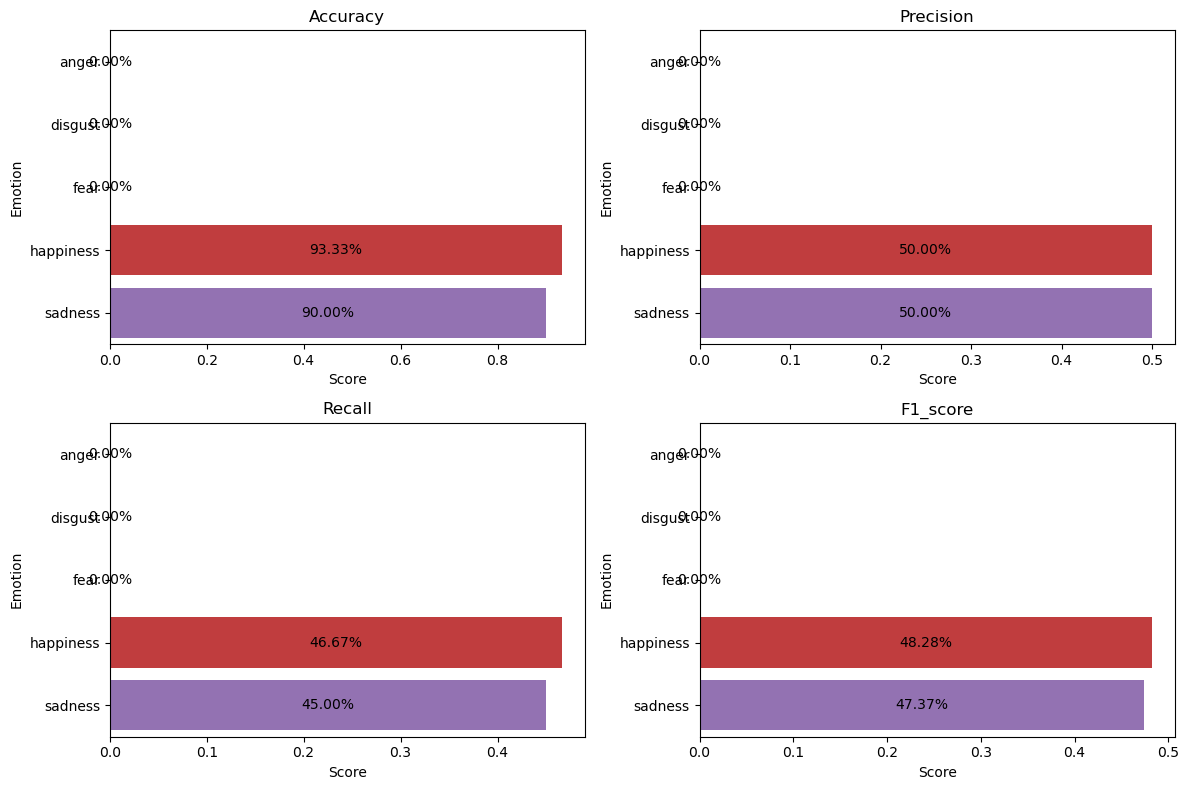

Overall Accuracy: 0.3485
Completed Fold 3 with Accuracy: 0.35
Average Accuracy: 0.27


In [7]:
#mfcc cnn
X, y_speakers, y_emotions = load_data_features(aug_dir, chosen='mfcc')
input_shape = (get_max_sequence_length(X), X[0].shape[0])  
prepare_and_evaluate(X, y_speakers, y_emotions, build_cnn_model, input_shape, epochs)

3/3 [==============================] - 2s 581ms/step


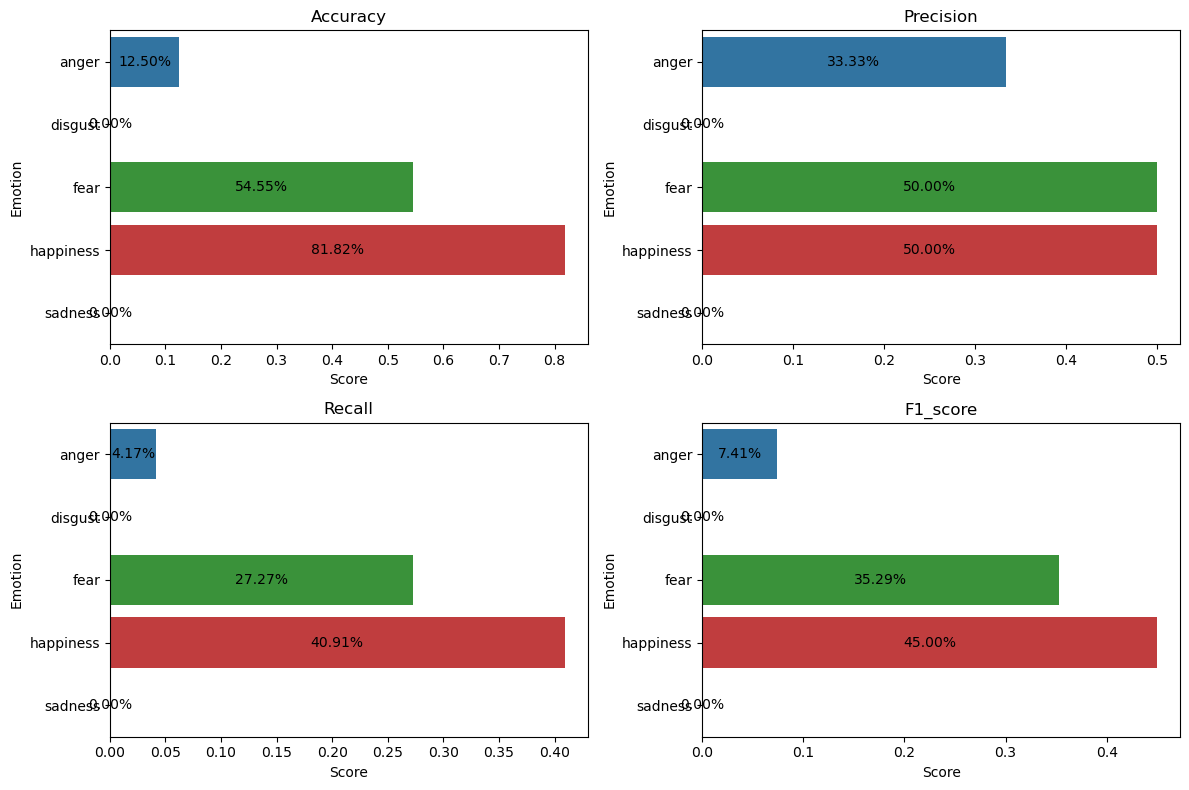

Overall Accuracy: 0.2537
Completed Fold 1 with Accuracy: 0.25
3/3 [==============================] - 3s 586ms/step


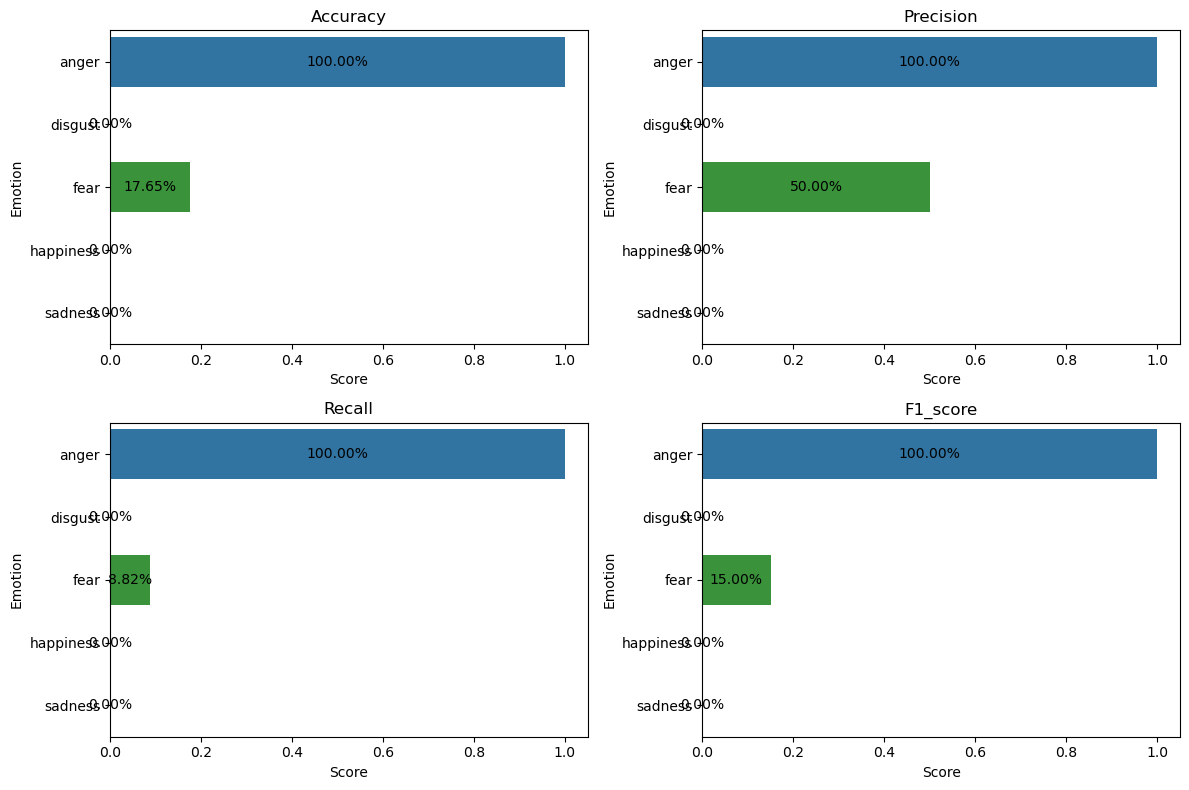

Overall Accuracy: 0.2239
Completed Fold 2 with Accuracy: 0.22
3/3 [==============================] - 2s 545ms/step


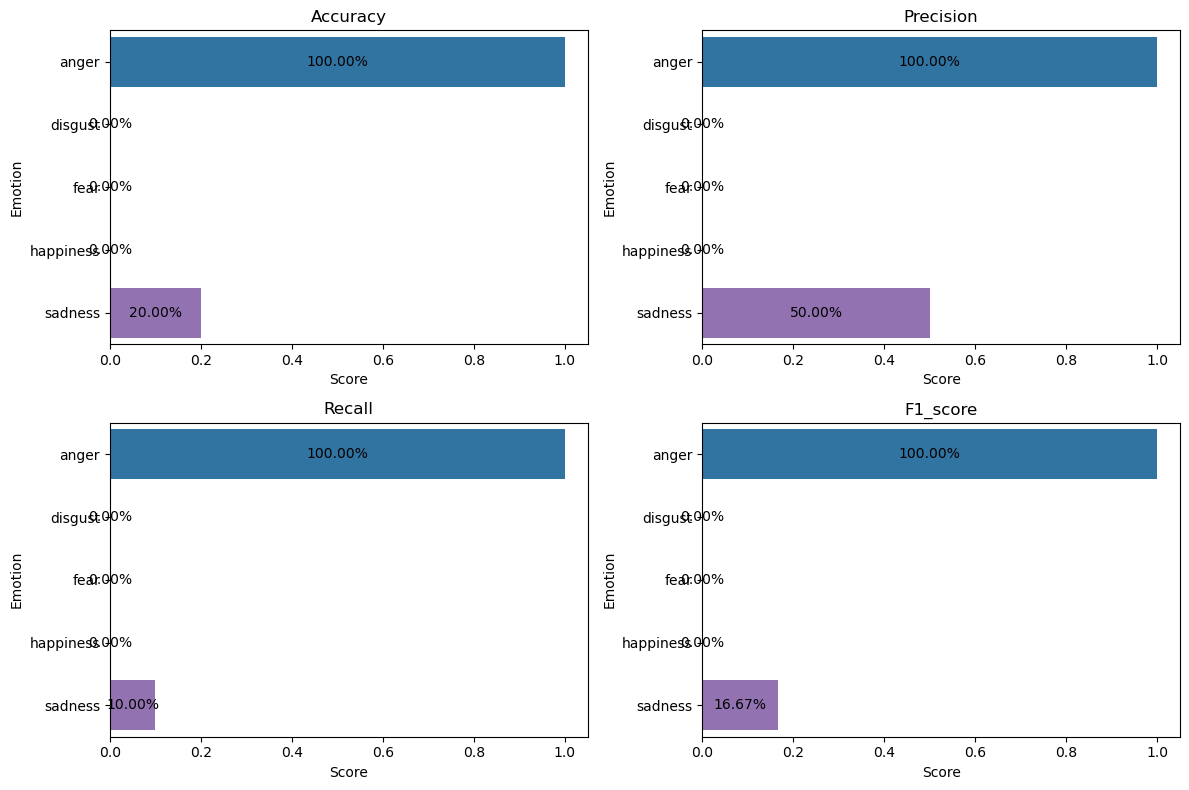

Overall Accuracy: 0.2121
Completed Fold 3 with Accuracy: 0.21
Average Accuracy: 0.23


In [8]:
#spectral lstm
X, y_speakers, y_emotions = load_data_features(aug_dir, chosen='spectral')
input_shape = (get_max_sequence_length(X), X[0].shape[0])  
prepare_and_evaluate(X, y_speakers, y_emotions, build_lstm_model, input_shape, epochs)


3/3 [==============================] - 0s 10ms/step


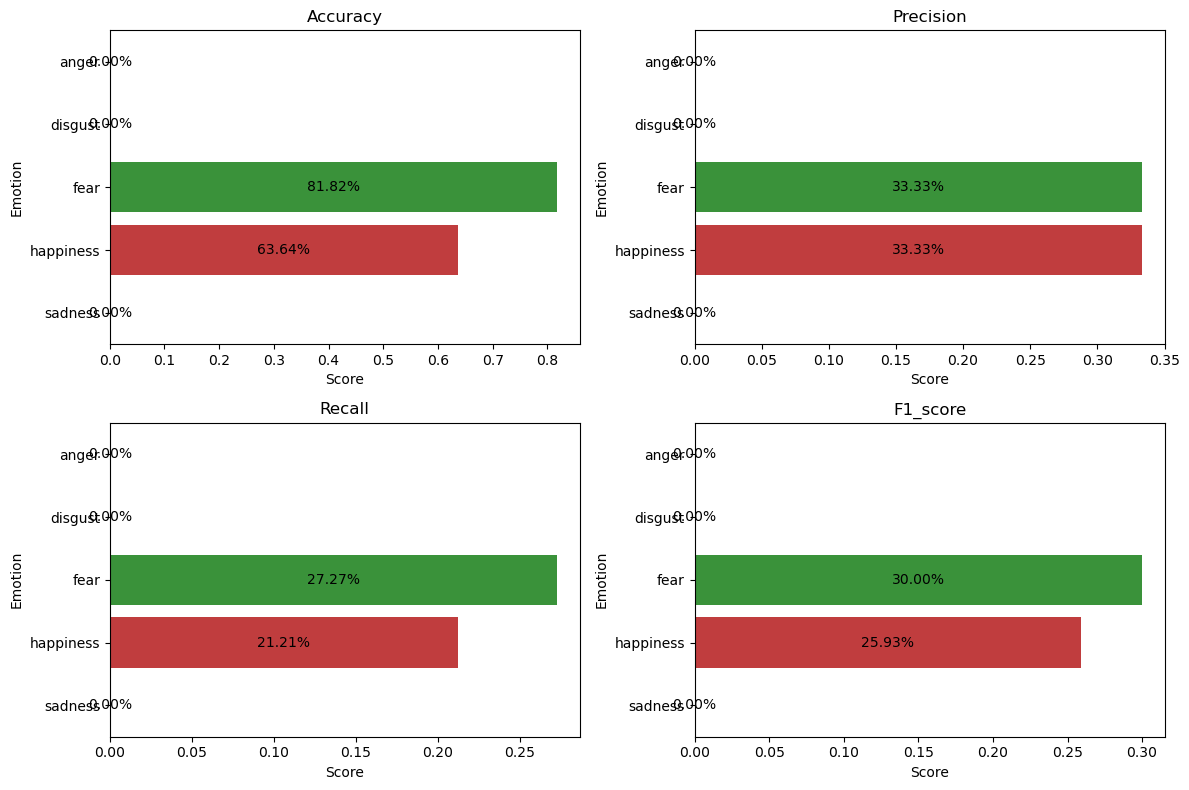

Overall Accuracy: 0.3433
Completed Fold 1 with Accuracy: 0.34
3/3 [==============================] - 0s 10ms/step


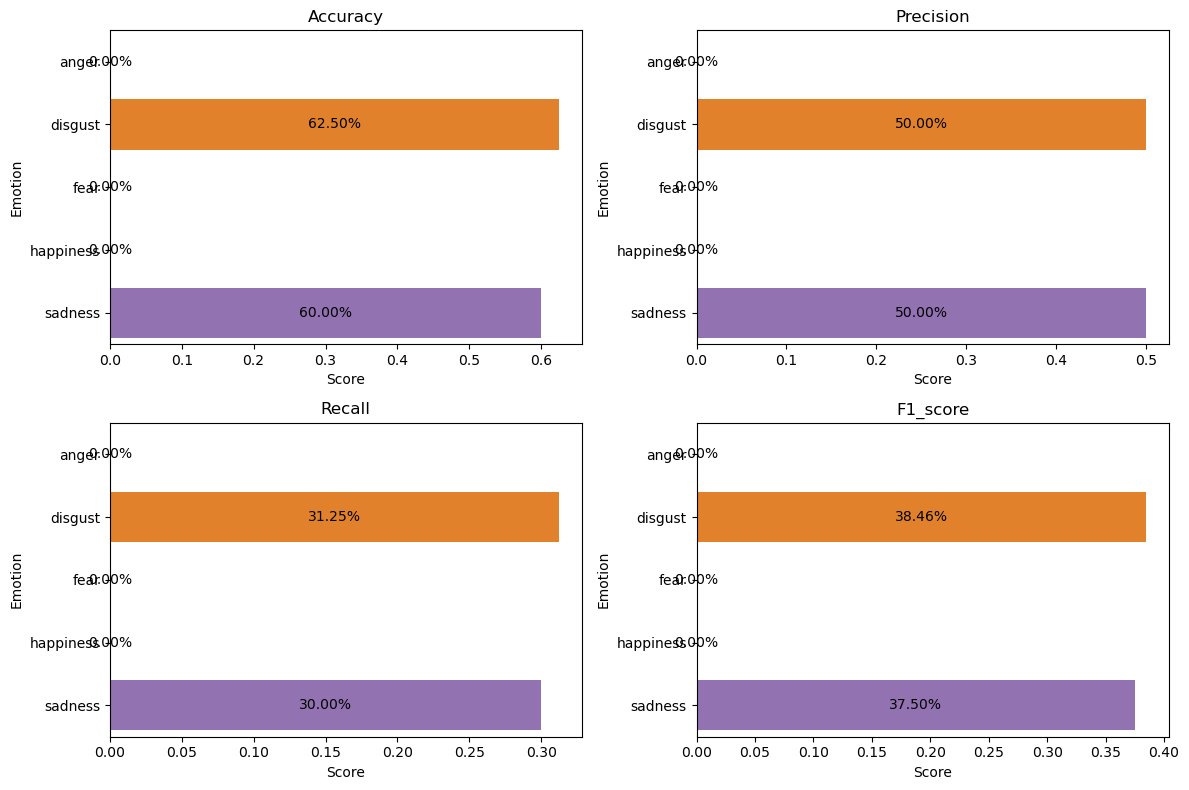

Overall Accuracy: 0.1940
Completed Fold 2 with Accuracy: 0.19
3/3 [==============================] - 0s 10ms/step


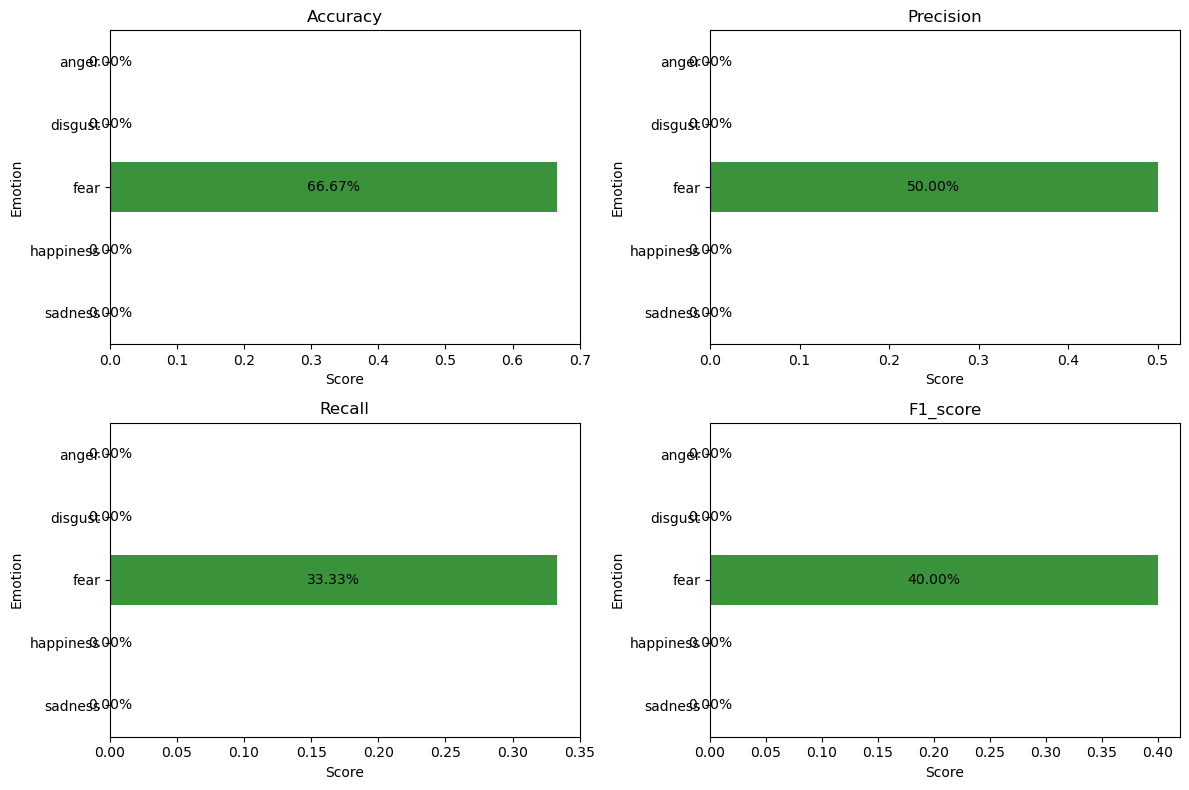

Overall Accuracy: 0.2121
Completed Fold 3 with Accuracy: 0.21
Average Accuracy: 0.25


In [9]:
#spectral cnn
X, y_speakers, y_emotions = load_data_features(aug_dir, chosen='spectral')
input_shape = (get_max_sequence_length(X), X[0].shape[0])  
prepare_and_evaluate(X, y_speakers, y_emotions, build_cnn_model, input_shape, epochs)


3/3 [==============================] - 2s 399ms/step


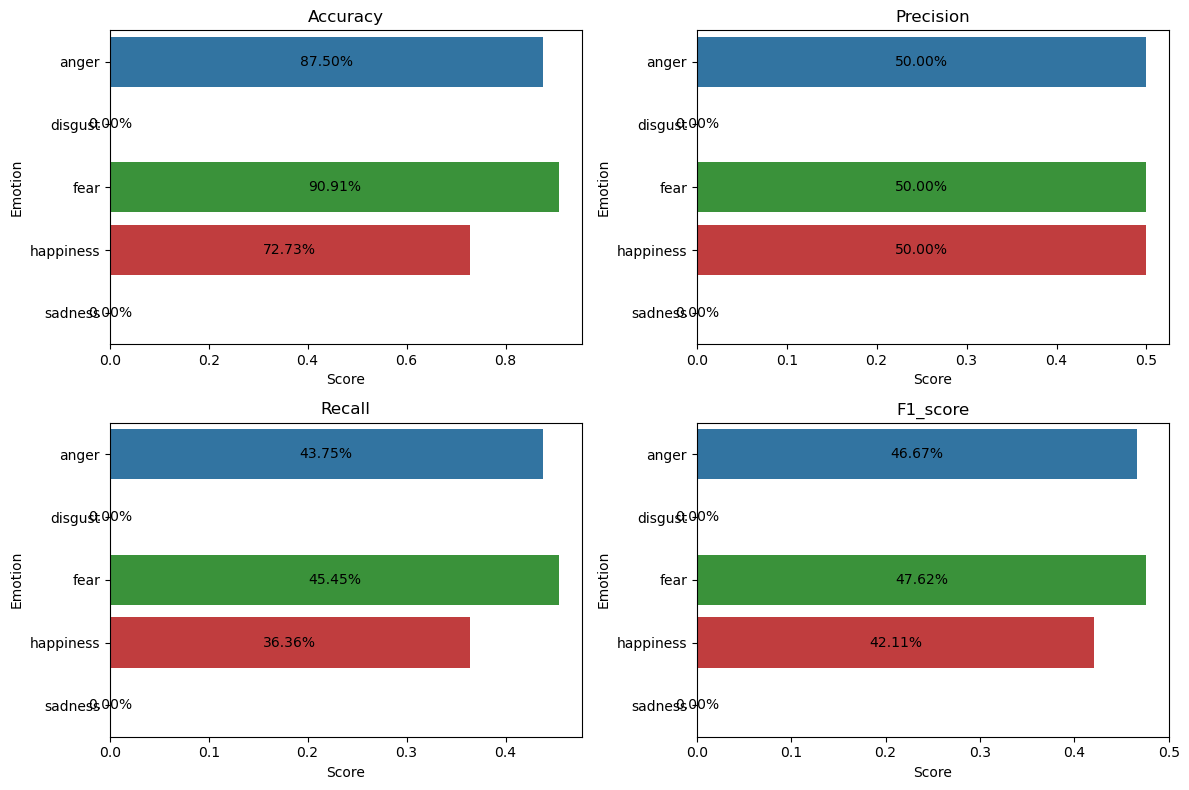

Overall Accuracy: 0.4776
Completed Fold 1 with Accuracy: 0.48
1/3 [=========>....................] - ETA: 14s - loss: 1.8062 - accuracy: 0.1250

KeyboardInterrupt: 

In [10]:
#combined lstm
X, y_speakers, y_emotions = load_data_features(aug_dir, chosen='combined')
input_shape = (get_max_sequence_length(X), X[0].shape[0])  
prepare_and_evaluate(X, y_speakers, y_emotions, build_lstm_model, input_shape, epochs)


Epoch 1/45
26/26 [==============================] - 81s 3s/step - loss: 19.2384 - accuracy: 0.3762 - val_loss: 0.9118 - val_accuracy: 0.6707
Epoch 2/45
26/26 [==============================] - 69s 3s/step - loss: 0.8583 - accuracy: 0.6893 - val_loss: 0.6512 - val_accuracy: 0.7572
Epoch 3/45
26/26 [==============================] - 63s 2s/step - loss: 0.5109 - accuracy: 0.8125 - val_loss: 0.4818 - val_accuracy: 0.8293
Epoch 4/45
26/26 [==============================] - 64s 2s/step - loss: 0.3259 - accuracy: 0.8894 - val_loss: 0.3560 - val_accuracy: 0.8726
Epoch 5/45
26/26 [==============================] - 62s 2s/step - loss: 0.2176 - accuracy: 0.9321 - val_loss: 0.3353 - val_accuracy: 0.8882
Epoch 6/45
26/26 [==============================] - 62s 2s/step - loss: 0.1588 - accuracy: 0.9489 - val_loss: 0.2537 - val_accuracy: 0.9050
Epoch 7/45
26/26 [==============================] - 60s 2s/step - loss: 0.1018 - accuracy: 0.9730 - val_loss: 0.3100 - val_accuracy: 0.8930
Epoch 8/45
26/26 [=

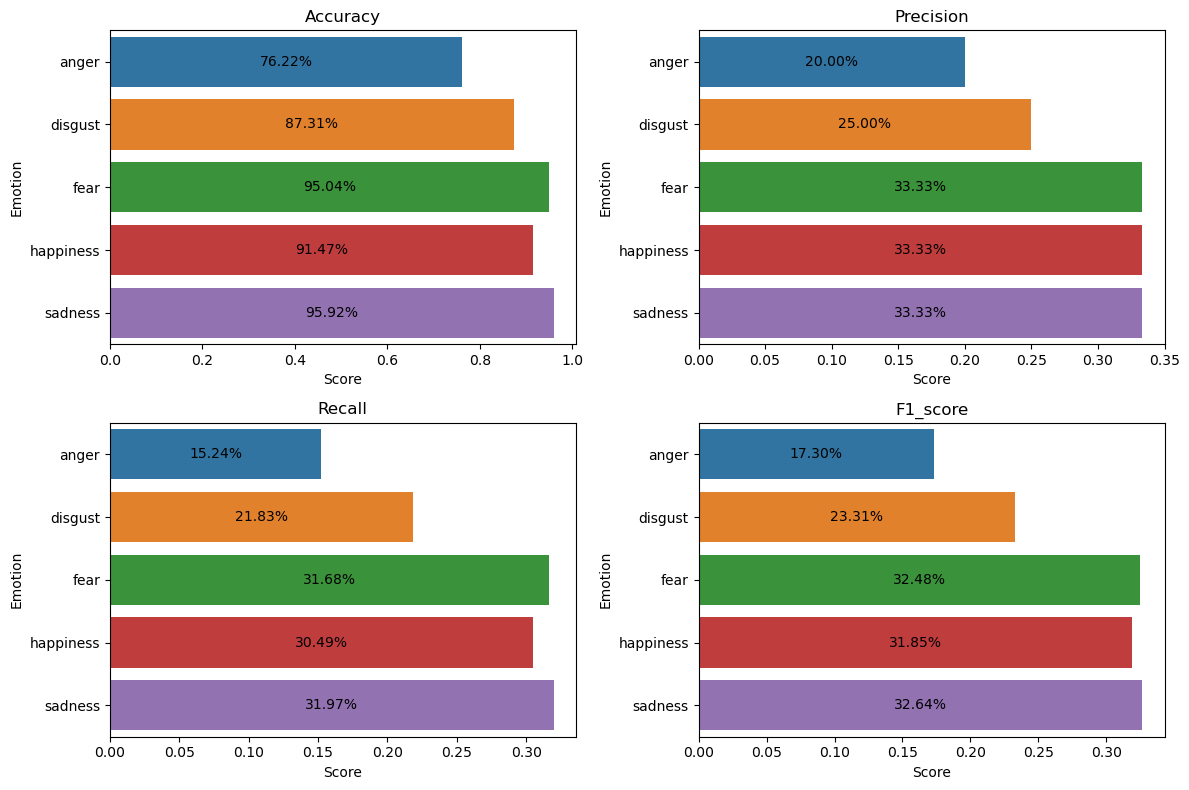

Overall Accuracy: 0.9099
Completed Fold 1 with Accuracy: 0.91
Epoch 1/45
26/26 [==============================] - 71s 3s/step - loss: 29.4396 - accuracy: 0.3113 - val_loss: 1.5290 - val_accuracy: 0.4147
Epoch 2/45
26/26 [==============================] - 71s 3s/step - loss: 1.2594 - accuracy: 0.4952 - val_loss: 0.9455 - val_accuracy: 0.6599
Epoch 3/45
26/26 [==============================] - 77s 3s/step - loss: 0.8719 - accuracy: 0.6779 - val_loss: 0.7629 - val_accuracy: 0.7296
Epoch 4/45
26/26 [==============================] - 80s 3s/step - loss: 0.5987 - accuracy: 0.7849 - val_loss: 0.5708 - val_accuracy: 0.7776
Epoch 5/45
26/26 [==============================] - 78s 3s/step - loss: 0.4324 - accuracy: 0.8389 - val_loss: 0.5285 - val_accuracy: 0.8185
Epoch 6/45
26/26 [==============================] - 78s 3s/step - loss: 0.3195 - accuracy: 0.8858 - val_loss: 0.4258 - val_accuracy: 0.8474
Epoch 7/45
26/26 [==============================] - 83s 3s/step - loss: 0.2647 - accuracy: 0.9075

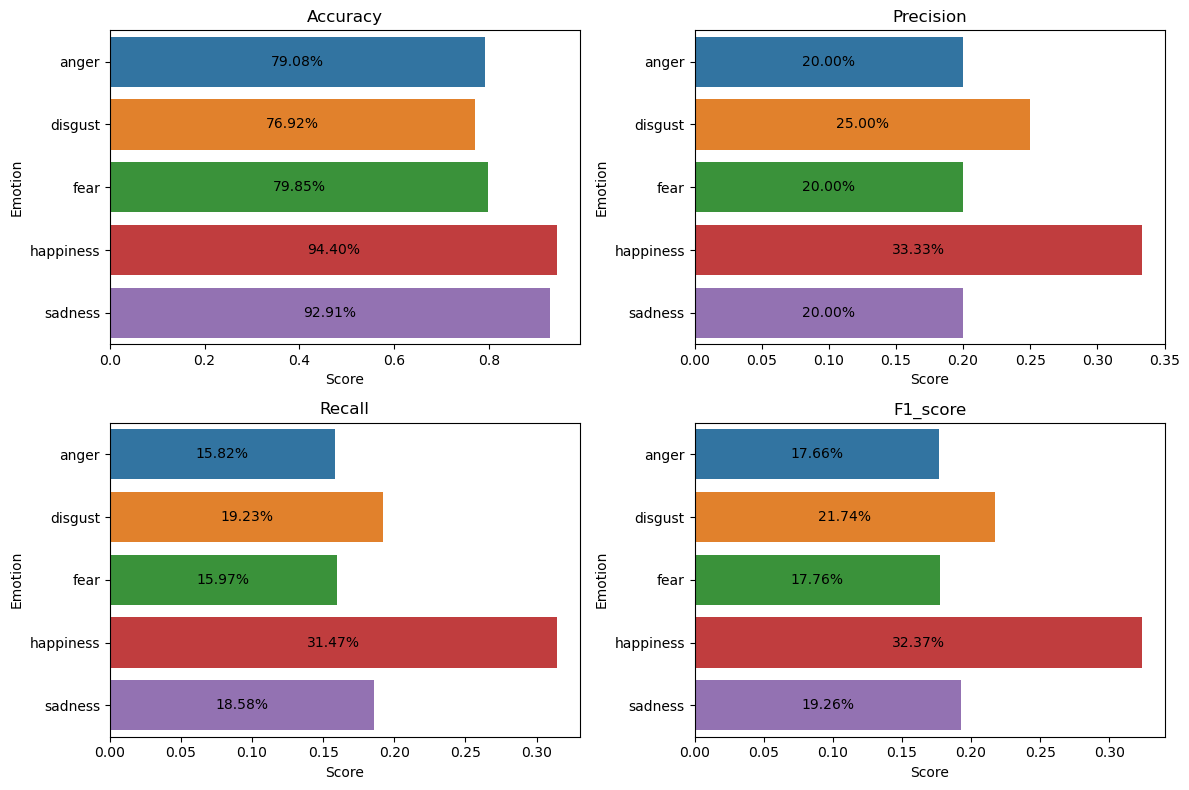

Overall Accuracy: 0.8654
Completed Fold 2 with Accuracy: 0.87
Epoch 1/45
26/26 [==============================] - 73s 3s/step - loss: 22.6783 - accuracy: 0.2915 - val_loss: 1.5745 - val_accuracy: 0.3858
Epoch 2/45
26/26 [==============================] - 72s 3s/step - loss: 1.4789 - accuracy: 0.3882 - val_loss: 1.2864 - val_accuracy: 0.4663
Epoch 3/45
26/26 [==============================] - 71s 3s/step - loss: 1.1538 - accuracy: 0.5306 - val_loss: 0.9230 - val_accuracy: 0.6250
Epoch 4/45
26/26 [==============================] - 69s 3s/step - loss: 0.8033 - accuracy: 0.6869 - val_loss: 0.7012 - val_accuracy: 0.7272
Epoch 5/45
26/26 [==============================] - 69s 3s/step - loss: 0.6043 - accuracy: 0.7794 - val_loss: 0.5438 - val_accuracy: 0.8125
Epoch 6/45
26/26 [==============================] - 68s 3s/step - loss: 0.4251 - accuracy: 0.8431 - val_loss: 0.4650 - val_accuracy: 0.8413
Epoch 7/45
26/26 [==============================] - 67s 3s/step - loss: 0.2894 - accuracy: 0.8894

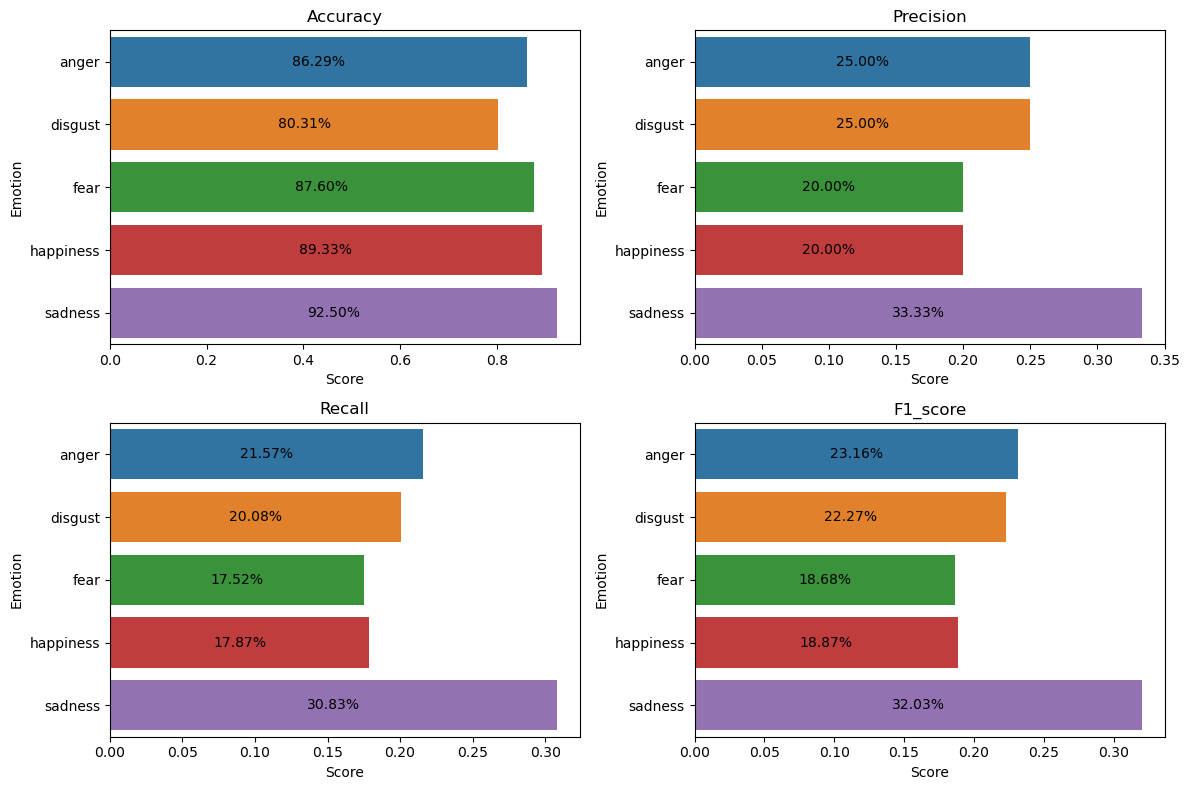

Overall Accuracy: 0.8966
Completed Fold 3 with Accuracy: 0.90
Average Accuracy: 0.89


In [ ]:
#combined cnn
X, y_speakers, y_emotions = load_data_features(aug_dir, chosen='combined')
input_shape = (get_max_sequence_length(X), X[0].shape[0])  
prepare_and_evaluate(X, y_speakers, y_emotions, build_cnn_model, input_shape, epochs)
